# Descripción
Primera versión del modelo de estimación de fechas de aprobacion sin mucha limpieza de datos

In [1]:
import numpy as np
import pandas as pd
import missingno as msn
import matplotlib.pyplot as plt
import os
import seaborn as sns


In [2]:
#Direccion del documento
#path=os.path.dirname(os.path.realpath('Ordenes%20de%20compra%20PORTAL%201K%20(datos%20completo).xlsx'))
#path

In [3]:
#Subir la dirección local de donde tengan los datos
df=pd.read_excel('C:\\Users\\Admin\\OneDrive\\Documentos\\DataScience2021-2\\Trabajos_propios_felipe\\Proyecto_final\\Ordenes de compra PORTAL 1K (datos completo).xlsx')

In [4]:
#Manejo inicial de base de datos
df.drop(labels=['Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28'],axis=1,inplace=True)
df.drop_duplicates(inplace=True)

#Cambiando formato de variables
df['FECHA ORDEN']=pd.to_datetime(df['FECHA ORDEN'],format='%Y-%m-%d',errors = 'coerce')
df['FECHA ENTREGA']=pd.to_datetime(df['FECHA ENTREGA'],format='%Y-%m-%d',errors = 'coerce')
df['FECHA APROBACION']=pd.to_datetime(df['FECHA APROBACION'],format='%Y-%m-%d',errors = 'coerce')
df['FECHA ULTIMO MOVIMIENTO']=pd.to_datetime(df['FECHA ULTIMO MOVIMIENTO'],format='%Y-%m-%d',errors = 'coerce')
df['PRECIO UNITARIO']=df['PRECIO UNITARIO'].apply(lambda x:float(x.replace('.','')))
df['PRECIO UNITARIO + IVA']=df['PRECIO UNITARIO + IVA'].apply(lambda x:float(x.replace('.','')))
df['IVA']=df['IVA'].apply(lambda x:float(x.replace('.','')))
df['TOTAL SIN IVA']=df['TOTAL SIN IVA'].apply(lambda x:float(x.replace('.','')))
df['TOTAL + IVA']=df['TOTAL + IVA'].apply(lambda x:float(x.replace('.','')))

#Eliminamos columnas que no usaremos
df.drop(labels=['CANTIDAD RECIBIDA','CENTRO DE COSTOS','PRESUPUESTO'],inplace=True,axis=1)



In [5]:
#Creacion de nuevos features

#Con las fechas de aprobacion
df['dia fecha aprobacion']=df['FECHA APROBACION'].dt.dayofweek #0 lunes, 6 domingo
df['mes fecha aprobacion']=df['FECHA APROBACION'].dt.month #Meses de aprobación 
df['semana del año aprobacion']=df['FECHA APROBACION'].dt.isocalendar().week

#Con las fechas de orden
df['dia fecha orden']=df['FECHA ORDEN'].dt.dayofweek #0 lunes, 6 domingo
df['mes fecha orden']=df['FECHA ORDEN'].dt.month #Meses de ordbación 
df['semana del año orden']=df['FECHA ORDEN'].dt.isocalendar().week

#Variable objetivo
df['dias para aprobación']=df['FECHA APROBACION']-df['FECHA ORDEN']
df['dias para aprobación']=(df['FECHA APROBACION']-df['FECHA ORDEN']).dt.days

In [6]:
#df.dropna(inplace=True)

In [7]:
#Los sias de aprobación superior a 7 dias los organizo para que sean 7
df['dias para aprobación']=np.where(df['dias para aprobación']>df['dias para aprobación'].quantile(0.75),
                                    df['dias para aprobación'].quantile(0.75),df['dias para aprobación'])

In [8]:
df['dias para aprobación'].describe()

count    21259.000000
mean         2.243662
std          2.991787
min          0.000000
25%          0.000000
50%          0.000000
75%          7.000000
max          7.000000
Name: dias para aprobación, dtype: float64

# MODELO

In [9]:
from pycaret.regression import *
from sklearn.model_selection import train_test_split

### Variables usadas para entrenar el modelo inicial:
- Dia fecha aprobacion = Dia de la semana que se aprobo la orden (lunes,martes...sabado,domingo)
- Dia fecha orden = Dia de la semana que se hizo la orden(lunes,martes...sabado,domingo)
- Mes fecha orden = Mes del año que se realizo la orden 
- semana del año orden = Semana del año que se hizo la orden
- Usuario aprobador = Usuario que aprueba la orden  
- Categoría = categoría del item que se ordena
### Variable objetivo
- dias para aprobación = Fecha aprobacion - fecha orden 

In [10]:
variables=df[[ 'dia fecha orden',
       'mes fecha orden', 'semana del año orden','dias para aprobación','USUARIO APROBADOR','CATEGORÍA']]

In [11]:
variables=variables.dropna()

In [12]:
#Acomodando los datos para entrarlos al modelo
variables['semana del año orden']=variables['semana del año orden'].astype('float64')
variables['dias para aprobación']=variables['dias para aprobación'].astype('int64')

In [13]:
#Datos de entrenamiento y prueba
train,test=train_test_split(variables,train_size=0.7,random_state=1234)
print('entrenamiento: ',train.shape)
print('test: ',test.shape)

entrenamiento:  (14881, 6)
test:  (6378, 6)


In [20]:
setup(train,target='dias para aprobación',
            train_size=0.7,
            preprocess=True,
            remove_multicollinearity=True,
            multicollinearity_threshold=0.8,
            numeric_features=['dia fecha orden',
                           'mes fecha orden','semana del año orden'],
            
            normalize=True,
            normalize_method='minmax',
      fold_shuffle=True
      
    
      
            );

,Description,Value
0,session_id,4990
1,Target,dias para aprobación
2,Original Data,"(14881, 6)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10416, 98)"


In [21]:
compare_models(fold=10,sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3032,0.6681,0.8160,0.9249,0.2902,0.1823,0.5740
et,Extra Trees Regressor,0.2871,0.6996,0.8349,0.9214,0.2938,0.1752,0.7220
xgboost,Extreme Gradient Boosting,0.3887,0.7160,0.8452,0.9195,0.3118,0.2277,0.7660
catboost,CatBoost Regressor,0.4235,0.7306,0.8539,0.9179,0.3191,0.2433,0.8700
dt,Decision Tree Regressor,0.2851,0.7675,0.8735,0.9138,0.3017,0.1763,0.0280
knn,K Neighbors Regressor,0.3433,0.8178,0.9027,0.9081,0.3269,0.2108,0.1140
lightgbm,Light Gradient Boosting Machine,0.4387,0.8430,0.9168,0.9051,0.3372,0.2502,0.1040
gbr,Gradient Boosting Regressor,0.5990,1.0745,1.0356,0.8791,0.4022,0.2872,0.2940
br,Bayesian Ridge,0.7077,1.4213,1.1917,0.8401,0.4480,0.3279,0.0890
ridge,Ridge Regression,0.7076,1.4213,1.1917,0.8401,0.4480,0.3280,0.0190


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=4990, verbose=0, warm_start=False)

In [25]:
#Elección de modelo
final_model=create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3333,0.7654,0.8749,0.9134,0.3025,0.1909
1,0.3007,0.6170,0.7855,0.9324,0.2848,0.1701
2,0.3085,0.7320,0.8556,0.9189,0.2960,0.1836
3,0.2837,0.5566,0.7461,0.9350,0.2815,0.1735
4,0.2994,0.6768,0.8227,0.9277,0.2862,0.1545
5,0.3085,0.6471,0.8044,0.9252,0.2818,0.1900
6,0.3034,0.6985,0.8358,0.9228,0.2784,0.1947
7,0.2733,0.5432,0.7370,0.9364,0.2794,0.1725
8,0.2989,0.6547,0.8091,0.9257,0.2954,0.2035
9,0.3228,0.7900,0.8888,0.9120,0.3161,0.1900


In [ ]:
# tune_rf=tune_model(estimator=final_model,optimize='RMSE',fold=8)
# tune_rf

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:29:09
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


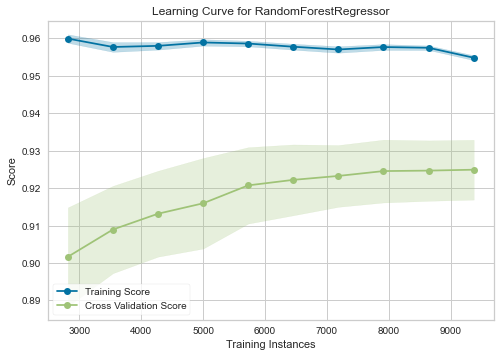

In [26]:
plot_model(final_model,plot='learning')

In [ ]:
plot_model(tune_rf,plot='learning')

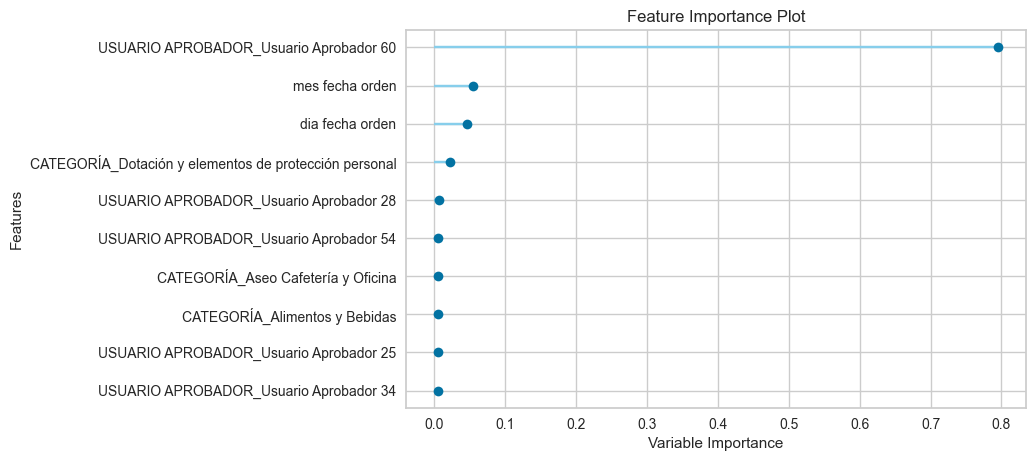

In [27]:
plot_model(final_model,plot='feature')

In [ ]:
plot_model(tune_rf,plot='feature')

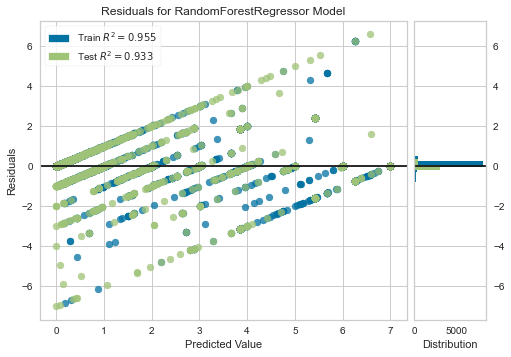

In [28]:
plot_model(final_model,plot='residuals')

In [ ]:
plot_model(final_model, plot='tree')

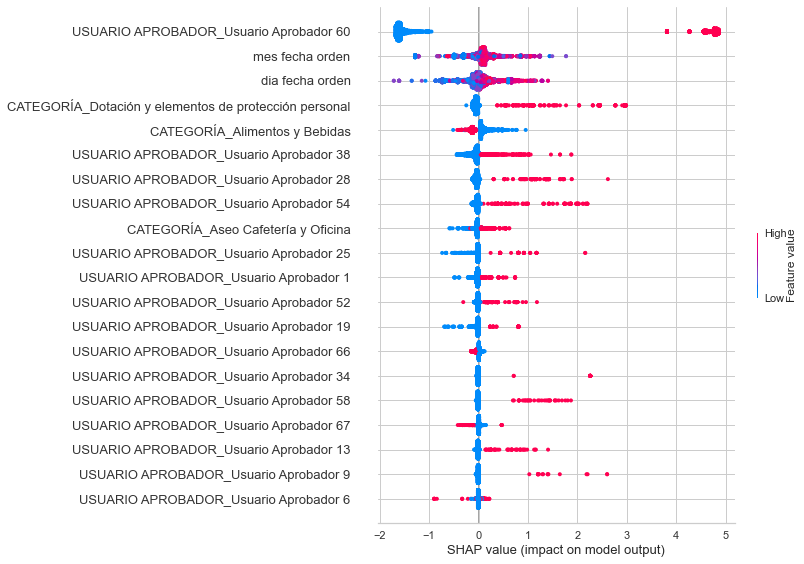

In [31]:
interpret_model(final_model)

In [29]:
predicciones=predict_model(final_model,data=test,round=0)
predicciones[['dias para aprobación','Label']].head(5)

,dias para aprobación,Label
22335,0,0.000000
22752,1,0.301507
10442,1,0.294962
17978,7,7.000000
12963,7,7.000000


In [33]:
predicciones

,dia fecha orden,mes fecha orden,semana del año orden,dias para aprobación,USUARIO APROBADOR,CATEGORÍA,Label
22335,3,6,25.0,0,Usuario Aprobador 66,Alimentos y Bebidas,0.000000
22752,0,5,22.0,1,Usuario Aprobador 66,Alimentos y Bebidas,0.171565
10442,4,12,49.0,1,Usuario Aprobador 4,Alimentos y Bebidas,0.285404
17978,3,11,48.0,7,Usuario Aprobador 60,Vigilancia y seguridad industrial,7.000000
12963,0,2,8.0,7,Usuario Aprobador 60,Vigilancia y seguridad industrial,7.000000
...,...,...,...,...,...,...,...
2122,4,9,35.0,0,Usuario Aprobador 6,Ferreteria,0.010000
21874,0,7,30.0,0,Usuario Aprobador 67,"Aseo, Cafetería y Oficina",0.000000
2847,2,8,32.0,0,Usuario Aprobador 1,Ferreteria,0.000000
16998,5,11,48.0,7,Usuario Aprobador 60,Vigilancia y seguridad industrial,7.000000


In [30]:
from sklearn.metrics import mean_squared_error,r2_score,median_absolute_error,explained_variance_score
mse=mean_squared_error(predicciones['dias para aprobación'],predicciones['Label'])
r2=r2_score(predicciones['dias para aprobación'],predicciones['Label'])
mae=median_absolute_error(predicciones['dias para aprobación'],predicciones['Label'])
explain_variance=explained_variance_score(predicciones['dias para aprobación'],predicciones['Label'])
print('MSE: ',mse)
print('RMSE: ',np.sqrt(mse))
print('R2: ',r2)
print('MAE: ',mae)


MSE:  0.6216566880917723
RMSE:  0.7884520835737403
R2:  0.9298102788852824
MAE:  0.0


In [ ]:
prediccionesE=predict_model(tune_rf,data=test,round=0)
mse=mean_squared_error(prediccionesE['dias para aprobación'],prediccionesE['Label'])
r2=r2_score(prediccionesE['dias para aprobación'],prediccionesE['Label'])
mae=median_absolute_error(prediccionesE['dias para aprobación'],prediccionesE['Label'])
explain_variance=explained_variance_score(prediccionesE['dias para aprobación'],prediccionesE['Label'])
print('MSE: ',mse)
print('RMSE: ',np.sqrt(mse))
print('R2: ',r2)
print('MAE: ',mae)


In [19]:
#save_model(final_model,'modelo_final',)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['dia fecha orden',
                                                           'mes fecha orden',
                                                           'semana del año '
                                                           'orden'],
                                       target='dias para aprobación',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_v...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=None,
         